In [13]:
import sys
import numpy as np
import tables
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator


In [2]:
from scipy.stats import norm
path = "/home/zelenyy/data/satellite/MCMC_1_69/mcmc_1_69.hdf5"

In [8]:
with tables.open_file(path) as h5file:
    table = h5file.get_node("/sim2100/deposit")
    print(repr(table.attrs))
    data = table.read()
    

/sim2100/deposit._v_attrs (AttributeSet), 21 attributes:
   [CLASS := 'TABLE',
    FIELD_0_FILL := 0.0,
    FIELD_0_NAME := 'event',
    NROWS := 10000,
    TITLE := 'Deposit in detector cell',
    VERSION := '2.7',
    path := 'sim2100',
    text := '/df/project test\n/df/gdml ../../satellite.gdml\n/satellite/output file\n/satellite/detector single\n\n/gps/particle proton\n/gps/number 1\n/gps/direction -0.49999999999999994 0.0 -0.8660254037844387\n/gps/ene/mono 30.0 MeV\n/gps/position 0.07499999999999998 0. 0.22990381056766582 m\n/run/beamOn 10000\n',
    values_macros_dirX := -0.49999999999999994,
    values_macros_dirZ := -0.8660254037844387,
    values_macros_energy := 30.0,
    values_macros_mode := 'single',
    values_macros_number := 10000,
    values_macros_particle := 'proton',
    values_macros_posX := 0.07499999999999998,
    values_macros_posZ := 0.22990381056766582,
    values_macros_radius := 0.15,
    values_macros_shift := 0,
    values_macros_theta := 30.0,
    values

In [9]:
data.dtype

dtype([('event', '<f4', (100,))])

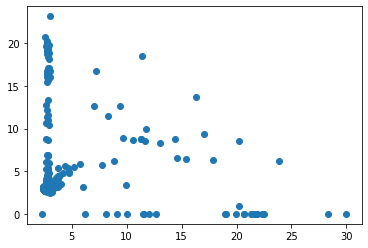

In [10]:
plt.scatter(data["event"][:, 0], data["event"][:,1])

In [11]:
np.all(data[0]==0.0)


/home/zelenyy/miniconda3/envs/phd-code/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  """Entry point for launching an IPython kernel.


False

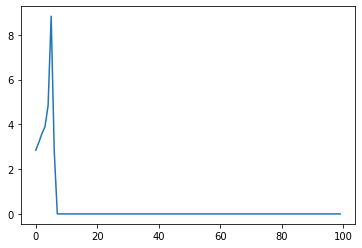

In [12]:
plt.plot(data["event"][0])

In [4]:
# path = "/mnt/storage2/phd/data/satellite/Anthracene/mean_anthracene.hdf5"
path = "/mnt/storage2/phd/data/satellite/polistyrene/proton.hdf5"


In [27]:
with tables.open_file(path) as h5file:
    data = h5file.get_node("/", "deposit").read()

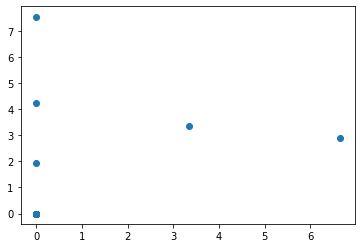

In [4]:
indx = data["shift"] == 0.0
plt.scatter(data["mean"][indx][0], data["mean"][indx][10])

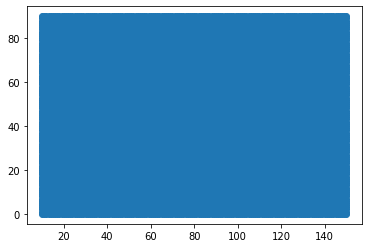

In [7]:
plt.scatter(data["energy"][indx], data["theta"][indx])

In [14]:
points = np.zeros(shape=(data.size, 3))
points[:, 0] = data["energy"][:]
points[:, 1] = data["theta"][:]
points[:, 2] = data["shift"][:]
values = data["mean"][:, 0]
values_std = np.sqrt(data["variance"][:, 0])

/home/zelenyy/miniconda3/envs/phd-code/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


In [15]:
%%time
interpolator = LinearNDInterpolator(points, values)
interpolator_std = LinearNDInterpolator(points, values_std)

CPU times: user 4min 18s, sys: 437 ms, total: 4min 19s
Wall time: 4min 19s


In [10]:
indx = np.logical_and(data["shift"] == 0.0, data["theta"] == 0.0)
test_points = data[indx]["energy"]



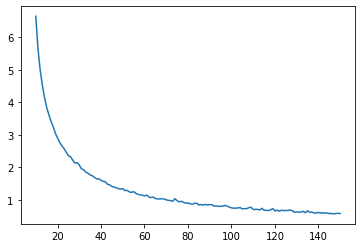

In [17]:
x = np.zeros(shape=(test_points.size, 3))
x[:, 0 ] = test_points
plt.plot(test_points, interpolator(x))

<ErrorbarContainer object of 3 artists>

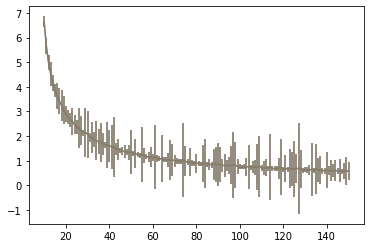

In [31]:
plt.errorbar(test_points, interpolator(x), yerr=interpolator_std(x))
plt.errorbar(test_points, values[indx], yerr=values_std[indx], alpha = 0.5)

In [12]:
class Likelihood:
    def __init__(self, interpolators_mean : LinearNDInterpolator, interpolators_std : LinearNDInterpolator):
        self.mean_list = interpolators_mean
        self.std_list  = interpolators_std

    def __call__(self, event: np.ndarray):
        sum_ = 0
        for i, temp in enumerate(zip(self.mean_list, self.std_list)):
            mean, std = temp
            mean = mean(event[i])
            std = std(event[i])
            sum_ += norm.logpdf(event[0], loc=mean, scale=std)
        return sum_

In [59]:
energy_norm, energy = Normilizer.get_with_array(data["energy"][:])   
theta_norm, theta = Normilizer.get_with_array(data["theta"][:])   
shift_norm, shift = Normilizer.get_with_array(data["shift"][:])

In [60]:
indx_energy = energy_norm.index_of_non_normed(data["energy"][:])
indx_theta = theta_norm.index_of_non_normed(data["theta"][:])
indx_shift = shift_norm.index_of_non_normed(data["shift"][:])

In [61]:
data_mesh = np.zeros(shape=(energy.size, theta.size, shift.size), dtype="d")

In [62]:
for i, item in enumerate(data["mean"]):
    data_mesh[indx_energy[i], indx_theta[i], indx_shift[i]] = item[0]



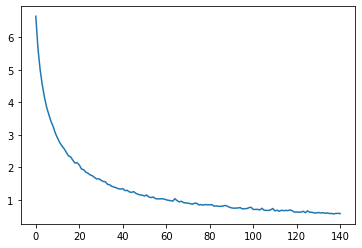

In [66]:
plt.plot(data_mesh[:, 0,0])

In [67]:
from scipy.interpolate import RegularGridInterpolator


In [68]:
%%time
grid_inter = RegularGridInterpolator((energy, theta, shift), data_mesh)

CPU times: user 253 µs, sys: 2 µs, total: 255 µs
Wall time: 262 µs


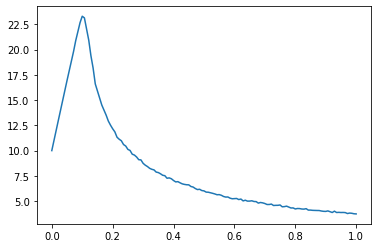

In [73]:
x = np.zeros(shape=(energy.size, 3))
x[:, 0] = energy
x[:, 1] = 0.9
plt.plot(energy, grid_inter(x))